In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import earthpy as et 
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import folium
from scipy import stats
import sklearn
from sklearn.preprocessing import StandardScaler

#Installation des différentes bibliothèques

#pip install geopandas
#pip install contextily
#pip install earthpy
#pip install folium
#pip install openpyxl
#pip install colorspacious

In [ ]:
pip install colorspacious

In [ ]:
#importation bdd nettoyées

mode_acces = pd.read_excel('mode_acces.xlsx')
motif_dep = pd.read_excel('motif_dep.xlsx')
distance_parcourue = pd.read_excel('distance_parcourue.xlsx')
freq_gare = pd.read_excel('freq_gare.xlsx')
intermodalite = pd.read_excel('intermodalite.xlsx')
wifi = pd.read_excel('wifi.xlsx')
travaux = pd.read_excel('travaux.xlsx')
temps_prec = pd.read_excel('temps_prec.xlsx')
type_clients = pd.read_excel('type_clients.xlsx')
csp_voyageurs = pd.read_excel('csp_voyageurs.xlsx')
age_voyageurs = pd.read_excel('age_voyageurs.xlsx')
genre_voyageurs = pd.read_excel('genre_voyageurs.xlsx')
referentiel_gare = pd.read_excel('referentiel_gare.xlsx')
frequentation_gares = pd.read_excel('frequentation_gares.xlsx')
satisfaction = pd.read_excel('clean_satisfaction.xlsx')
satis_gare = pd.read_excel('clean_satisfaction_uniq_gare.xlsx')

In [ ]:
# 1. STATISTIQUES DESCRIPTIVES

In [ ]:
# 1.1 GARES SITUEES SUR UNE CARTE FRANÇAISES ET LEUR NIVEAU DE SATISFACTION

In [ ]:
# CRÉATION DF MERGE GARES X LOCALISATION

#chaque gare est identifiée par son code UIC (clé SNCF)

In [ ]:
satis_gare = satis_gare.rename(columns={'Code UIC': 'uic_code'})

In [ ]:
# dans la base referentiel_gares, les codes uic étaient précédés du numéro '87' (code trains français)
referentiel_gare['uic_code'] = referentiel_gare['uic_code'].apply(lambda s: s-87000000)

In [ ]:
#suppression valeurs manquantes satisfaction 2017

satis_gare = satis_gare[satis_gare['mars 2021']!='-']

In [ ]:
#satis_loc : merge satisfaction (2017) x localisation de la gare
#colonnes: code UIC (clé de la gare), Gare, satisfaction 2017, UG gare, coordonnées longitude/latitude wgs84 (2 colonnes)
#ATTENTION: slt 156 gares dans satif_loc --> gares enquétées sur la satisfaction. On suppose qu'il s'agit d'un échantillon représentatif des gares françaises

satis_loc = satis_gare[['uic_code', 'Gare', 'mars 2021', 'UG']].set_index('uic_code').merge(referentiel_gare[['uic_code', 'wgs_84.lon', 'wgs_84.lat']].set_index('uic_code'), on='uic_code')

In [ ]:
satis_loc = satis_loc.rename(columns={'mars 2021': 'satisfaction-2021'})

In [ ]:
satis_loc=satis_loc.reset_index()
#on enlève les index dans un 1er temps pour que les colonnes soient des listes et non des pandas series

In [ ]:
# CREATION CARTE FRANCAISES GARES - 1ere VERSION (cartes non interactives)

#layering: fond de carte (découpage france métropolitaine par départements) + position des gares enquétées

In [ ]:
###1ere CARTE: niveau france métropolitaine

#importation de la base donnée contenant le découpage de la france métropolitaine selon les départements
#format shapefile

departement = gpd.read_file("departements-20180101.shp", crs="EPSG:4326")

###2eme carte: Zomm sur paris intra-muros (pour des raisons de lisibilité)

#importation de la base de donnée contenant le découpage de paris intramuros

arrondissements = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
arrondissements = arrondissements.rename(columns = {"c_arinsee": "insee"})
arrondissements['insee'] = arrondissements['insee'].astype(str)

In [ ]:
#filtrage: on garde seulement les départements de France métropolitaine (suppression outre mer)

l=[]
for i in range (departement.shape[0]):
    l.append(len(departement['code_insee'][i])<3)
    
departement = departement[l]   

In [ ]:
#on convertit les coordonnées wgs84 (sous forme xy) en format Point (shapefile), compatible avec les geometries geopandas

wgs84_points = []
for i in range (satis_loc.shape[0]):
    wgs84_points.append(Point([satis_loc['wgs_84.lon'][i], satis_loc['wgs_84.lat'][i]]))

satis_loc['geometry'] = wgs84_points

In [ ]:
#conversion du dataframe en GeoDataFrame

loc_gares_gpd = gpd.GeoDataFrame(satis_loc, crs="EPSG:4326")

In [ ]:
#visualisation des gares
#!! TOUTES LES REGIONS DE FRANCE SEMBLENT ETRE REPRESENTEES DANS NOTRE ECHANTILLON

loc_gares_gpd.plot(marker='*', color='green', markersize=5)

In [ ]:
import colorspacious
from matplotlib import cm
from colorspacious import cspace_converter
import matplotlib as mpl


In [ ]:
fig,ax = plt.subplots(2, figsize=(15, 15))
departement.plot(ax = ax[0], color='white', edgecolor='black')

loc_gares_gpd.plot(ax=ax[0], marker='o', markersize=40, column='satisfaction-2021', cmap='Oranges')
ax[0].set_title('Gares enquétées en France Métropolitaine et leur niveau de satisfaction', fontsize=12)
ax[0].set_axis_off()
#ax[0].legend()
ax[0]

arrondissements.plot(ax = ax[1], zorder=1, edgecolor = "black", facecolor="none", color = None)
loc_gares_gpd[loc_gares_gpd['UG'].isin(['Paris Sud', 'Paris Nord'])][loc_gares_gpd['wgs_84.lon']<2.5][loc_gares_gpd['wgs_84.lat']>48.8].plot(ax=ax[1], marker='o', markersize=50, column='satisfaction-2021', cmap='Oranges')
ax[1].set_title('Gares enquétées dans Paris intramuros et leur niveau de satisfaction', fontsize=12)
ax[1].set_axis_off()
#ax[1].legend()
ax[1]

fig.suptitle('Localisation des gares enquétées et leur niveau de satisfaction en 2021' + "\n " + 'du plus clair (moins satisfaisant) au plus foncé (plus satisfaisant)', fontsize=15)


## si tu trouves comment ajouter la légende des couleurs en dégradé c'est cool (avec l'intervalle sur lequel s'étale la satisfaction)

In [ ]:
# AUTRE CARTE: interactive 

In [ ]:
#pour la carte interactive:

from pathlib import Path
Path("leaflet").mkdir(parents=True, exist_ok=True)

In [ ]:
#pour le dégradé de couleur (de bleu clair à bleu foncé, pour le niveau de satisfaction dans chaque gare)

import seaborn as sns
pal = sns.color_palette("Blues", n_colors=satis_loc.shape[0])

In [ ]:
#bdd triée dans l'ordre croissant

satis_loc = satis_loc.sort_values(['satisfaction-2021'], ascending=True)

In [ ]:
# attribution d'une couleur à chaque gare: de bleu clair (pour les moins stisfaisantes) à bleus foncés (pour les + satisfaisantes)

satis_loc["color"]=pal.as_hex()

In [ ]:
# création de la carte interactive :
#  - dégradé de couleur selon le niveau de stisfaction (de bleu clair (pour les moins stisfaisantes) à bleus foncés (pour les + satisfaisantes))
#  - taille du cerle de la gare fonction (croissante) du niveau de satisfaction
#  - cliquer sur un cercle pour avoir le nom de la gare et son niveau de satisfaction :)



center = satis_loc[['wgs_84.lat', 'wgs_84.lon']].mean().values.tolist()
sw = satis_loc[['wgs_84.lat', 'wgs_84.lon']].min().values.tolist()
ne = satis_loc[['wgs_84.lat', 'wgs_84.lon']].max().values.tolist()



m = folium.Map(location = center, tiles='Stamen Toner')

for i in range(0,len(satis_loc)):
   folium.Circle(
      location=[satis_loc.iloc[i]['wgs_84.lat'], satis_loc.iloc[i]['wgs_84.lon']],
      popup= str(satis_loc.iloc[i]['Gare']) + ": <br> " + str(satis_loc.iloc[i]['satisfaction-2021']),
      radius=np.exp(satis_loc.iloc[i]['satisfaction-2021']+2),
      color='black',
      weight = 1,
      fill=True,
      fill_color=satis_loc.iloc[i]['color'],
      fill_opacity=0.9
   ).add_to(m)
m.fit_bounds([sw, ne])
m

In [ ]:
# 1.2_ autres statistiques descriptives --> a faire (qqchose en rapport avec les régression? représentation moyenne + écart type de chaque variable?
# utiliser le tableau satis_merge_all créé en dessous

# 1.2_ autres statistiques descriptives --> a faire (qqchose en rapport avec les régression? représentation moyenne + écart type de chaque variable?
# utiliser le tableau satis_merge_all créé en dessous


#Fréquentation par gare
frequentation_gares=frequentation_gares.rename(columns={"code_uic_complet" : "uic_code"})
freq_loc = frequentation_gares.set_index('uic_code').merge(referentiel_gare[['uic_code', 'wgs_84.lon', 'wgs_84.lat']].set_index('uic_code'), on='uic_code')

freq_loc = freq_loc.sort_values(['totalvoyageurs2017'], ascending=True)

pal2 = sns.color_palette("Blues", n_colors=freq_loc.shape[0])
freq_loc["color"]=pal2.as_hex()
freq_loc=freq_loc.dropna()
center = freq_loc[['wgs_84.lat', 'wgs_84.lon']].mean().values.tolist()
sw = freq_loc[['wgs_84.lat', 'wgs_84.lon']].min().values.tolist()
ne = freq_loc[['wgs_84.lat', 'wgs_84.lon']].max().values.tolist()



n = folium.Map(location = center, tiles='Stamen Toner')

for i in range(0,len(freq_loc)):
   folium.Circle(
      location=[freq_loc.iloc[i]['wgs_84.lat'], freq_loc.iloc[i]['wgs_84.lon']],
      popup= str(freq_loc.iloc[i]['nom_gare']) + ": <br> " + str(freq_loc.iloc[i]['totalvoyageurs2017']),
      radius=np.sqrt(freq_loc.iloc[i]['totalvoyageurs2017']),
      color='black',
      weight = 1,
      fill=True,
      fill_color=freq_loc.iloc[i]['color'],
      fill_opacity=0.9
   ).add_to(n)
n.fit_bounds([sw, ne])
n
#Fréquentation par gare 
#freq_loc = freq_gare[['uic_code', 'Gare', 'mars 2021', 'UG']].set_index('uic_code').merge(referentiel_gare[['uic_code', 'wgs_84.lon', 'wgs_84.lat']].set_index('uic_code'), on='uic_code')

In [ ]:
distance_parcourue_wide = distance_parcourue.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='classe_distance_gare_gare', values='pourcentage')
motif_dep_wide = motif_dep.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='motif_du_deplacement', values='pourcentage')
freq_gare_wide = freq_gare.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='frequence', values='pourcentage')
type_clients_wide = type_clients.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='type_d_usager', values='pourcentage')
age_voyageurs_wide = age_voyageurs.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='classe_d_age', values='pourcentage')
genre_voyageurs_wide = genre_voyageurs.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='sexe', values='pourcentage')

frequentation_gares_wide = frequentation_gares[['uic_code','totalvoyageurs2017']].copy()
frequentation_gares_wide['uic_code']=frequentation_gares_wide['uic_code'].apply(lambda x : int(str(x).lstrip("87")))
frequentation_gares_wide.set_index("uic_code")

#faire une base travaux avec le niveau de travaux indiqués dans la base satisfaction

In [ ]:
#grande table mergée: pour chaque gare: niveau satisfaction + répartition selon:
#                                                                                - distance parcourue
#                                                                                - motif de déplacement 
#                                                                                - fréquence de venue dans la gare
#                                                                                - type de clients
#                                                                                - tranche d'âge voyageurs
#                                                                                - genre voyageurs
#.merge(frequentation_gares_wide, on='uic_code')


satis_merge_all = satis_gare[['uic_code', 'Gare', 'mars 2021', 'UG']].set_index('uic_code').merge(distance_parcourue_wide, on='uic_code').merge(motif_dep_wide, on='uic_code').merge(freq_gare_wide, on='uic_code').merge(type_clients_wide, on='uic_code').merge(age_voyageurs_wide, on='uic_code').merge(genre_voyageurs_wide, on='uic_code').merge(frequentation_gares_wide, on='uic_code')

satis_merge_all

In [ ]:
# variable mean_year moyenne d'âge estimée des voyageurs

satis_merge_all = satis_merge_all.assign(mean_age=lambda x: (satis_merge_all['19 ans et moins']*15 + satis_merge_all['20 ans à 29 ans']*25 +  satis_merge_all['30 ans à 39 ans']*35 + satis_merge_all['40 ans à 49 ans']*45 + satis_merge_all['50 ans à 59 ans']*55 + satis_merge_all['60 ans et plus']*65)/100)

#regroupement variables distance parcourue
satis_merge_all['Moins de 50km'] = satis_merge_all['Moins de 25 km'] + satis_merge_all['25 à 50 km']
satis_merge_all['50 à 100km'] = satis_merge_all['50 à 75 km'] + satis_merge_all['75 à 100 km']
satis_merge_all['100 à 200km'] = satis_merge_all['100 à 150 km'] + satis_merge_all['150 à 200 km']
satis_merge_all['200 à 400km'] = satis_merge_all['200 à 250 km'] + satis_merge_all['250 à 300 km'] + satis_merge_all['300 à 400 km']
satis_merge_all['plus de 400km'] = satis_merge_all['400 à 500 km'] + satis_merge_all['Plus de 500 km']
satis_merge_all

In [143]:
# Statistiques descriptives

#Nombre total de voyageurs, moyenne et mediane par gare
# Combien de gares réalisent 10, 50, 90 % du trafic ?
# Age moyen, age médian
# Longueur moyenne trajet

frequentation_gares_wide['totalvoyageurs2017'].describe()


count    2.967000e+03
mean     9.316576e+05
std      6.223996e+06
min      0.000000e+00
25%      8.257500e+03
50%      4.553700e+04
75%      2.433595e+05
max      2.480071e+08
Name: totalvoyageurs2017, dtype: float64

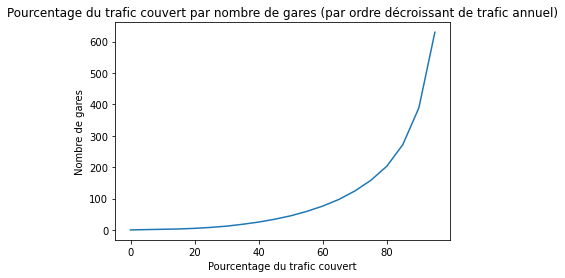

In [145]:

nb2017=frequentation_gares_wide['totalvoyageurs2017'].sum()
frequentation_gares_wide = frequentation_gares_wide.sort_values(['totalvoyageurs2017'], ascending=False, ignore_index=True)

def nombre_gares(val) : 
    n=0
    s=0
    while s<nb2017*val :
        s=s+frequentation_gares_wide['totalvoyageurs2017'][n]
        n=n+1
    return(n)

X=np.arange(0,1,0.05)
Y=[nombre_gares(x) for x in X]
X=X*100
plt.plot(X,Y)
plt.title("Pourcentage du trafic couvert par nombre de gares (par ordre décroissant de trafic annuel)")
plt.xlabel("Pourcentage du trafic couvert")
plt.ylabel("Nombre de gares")
plt.show()


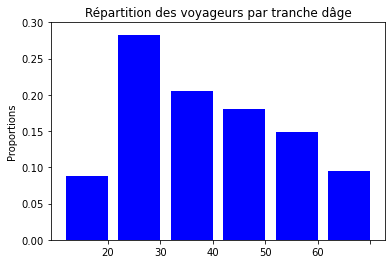

In [136]:
#Age moyen (repondéré par la fréquentation par gare)
age_pond=frequentation_gares_wide.merge(age_voyageurs_wide, on='uic_code')
moins19=(age_pond['19 ans et moins']*age_pond['totalvoyageurs2017']).sum()
vingtaine=(age_pond['20 ans à 29 ans']*age_pond['totalvoyageurs2017']).sum()
trentaine=(age_pond['30 ans à 39 ans']*age_pond['totalvoyageurs2017']).sum()
quarantaine=(age_pond['40 ans à 49 ans']*age_pond['totalvoyageurs2017']).sum()
cinquantaine=(age_pond['50 ans à 59 ans']*age_pond['totalvoyageurs2017']).sum()
plus60=(age_pond['60 ans et plus']*age_pond['totalvoyageurs2017']).sum()
x = [0,1,2,3,4,5]
val = [moins19,vingtaine,trentaine,quarantaine,cinquantaine,plus60]
tot = sum(val)
val=val/tot
width = 0.8 

fig, ax = plt.subplots()
rects1 = ax.bar(x, val, width, color='b')

ax.set_ylim(0,0.3)
ax.set_ylabel('Proportions')
ax.set_title('Répartition des voyageurs par tranche dâge')
ax.set_xticks(np.add(x,(width/2))) # set the position of the x ticks
ax.set_xticklabels(('20', '30', '40', '50', '60',''))


val
plt.show()

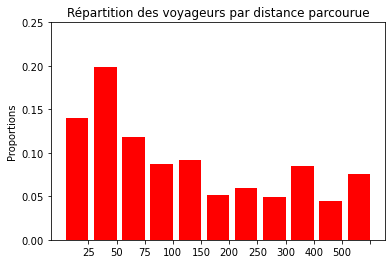

In [142]:
# Répartition des voyageurs par longueur du trajet
distan_pond=frequentation_gares_wide.merge(distance_parcourue_wide, on='uic_code')
A=(distan_pond['Moins de 25 km']*distan_pond['totalvoyageurs2017']).sum()
B=(distan_pond['25 à 50 km']*distan_pond['totalvoyageurs2017']).sum()
C=(distan_pond['50 à 75 km']*distan_pond['totalvoyageurs2017']).sum()
D=(distan_pond['75 à 100 km']*distan_pond['totalvoyageurs2017']).sum()
E=(distan_pond['100 à 150 km']*distan_pond['totalvoyageurs2017']).sum()
F=(distan_pond['150 à 200 km']*distan_pond['totalvoyageurs2017']).sum()
G=(distan_pond['200 à 250 km']*distan_pond['totalvoyageurs2017']).sum()
H=(distan_pond['250 à 300 km']*distan_pond['totalvoyageurs2017']).sum()
I=(distan_pond['300 à 400 km']*distan_pond['totalvoyageurs2017']).sum()
J=(distan_pond['400 à 500 km']*distan_pond['totalvoyageurs2017']).sum()
K=(distan_pond['Plus de 500 km']*distan_pond['totalvoyageurs2017']).sum()

x = [0,1,2,3,4,5,6,7,8,9,10]
val = [A,B,C,D,E,F,G,H,I,J,K]
tot = sum(val)
val=val/tot
width = 0.8 

fig, ax = plt.subplots()
rects1 = ax.bar(x, val, width, color='r')

ax.set_ylim(0,0.25)
ax.set_ylabel('Proportions')
ax.set_title('Répartition des voyageurs par distance parcourue')
ax.set_xticks(np.add(x,(width/2))) # set the position of the x ticks
ax.set_xticklabels(('25', '50', '75', '100', '150','200','250','300','400','500',''))


val
plt.show()

In [ ]:
# 2.ANALYSE QUANTITATIVE 

In [ ]:
# 2.1 Régressions linéaires

In [ ]:
# Dans le bus d'étudier les déterminants de la satisfacion en gare, on s'intéresse aux liens potentiels entre les variables liées aux 
# caractéristiques des voyageurs (sexe, age) et à celles de leur voyage (motif, distance...) dans chaque gare. 
# On régresse  donc la variable de satisfaction sur une sélection de variables sur les voyageurs


lvar = ['Déplacement domicile - travail habituel', 'Déplacement domicile - étude (y compris stage)',
       'Déplacement professionnel occasionnel',
       "Loisirs, vacances, visite d'un proche ou ami", 'Moins de 50km', '50 à 100km',
       '100 à 200km', '200 à 400km', 'plus de 400km', 'mean_age', 'F']

for var in lvar:
    x = np.array(satis_merge_all.dropna(subset=[var])[var].tolist())
    y = np.array(satis_merge_all.dropna(subset=[var])['mars 2021'].tolist())


    res = stats.linregress(x, y)
    print(var)
    print(f"slope: {res.slope:.6f}")
    print(f"pvalue: {res.pvalue:.6f}")
    print(f"R-carré: {res.rvalue**2:.6f}")

    plt.plot(x, y, 'o', label='données observées')
    plt.plot(x, res.intercept + res.slope*x, 'r', label='valeurs prédites')
    plt.legend()
    plt.show()

In [ ]:
# interprétations régressions linéaires: 

#1er point: une bonne partie des régressions est inutile, avec des p-valeurs parfois très grandes. 
#Ainsi, on ne peut pas affirmer que les variables: 
#                                                   - Déplacement domicile - travail habituel
#                                                   - Moins de 50km
#                                                   - 50 à 100km
#                                                   - 100 à 200km
#on un effet significatif sur le niveau de satisfaction global.


#2ème point: certaines autres variables sont statistiquement significatives, mais avec toutefois un effet marginal très faible
#par exemple la variable 200 à 400km est statistiquement significative au seuil de 5%, mais on estime qu'une augmentation de 10 points 
#de pourcentage de la proportion de personnes parcourant 200 à 400km de 10 points de pourcentage est associée en moyenne à une hausse
#de la satisfaction globale de 0.09 points sur 10, ce qui est négligeable.

#3ème point: les R2 sont assez faible, ce qui est normal: les régressions présentées n'intègrent qu'une seule variable liée à une 
#caractéristique des individus, ce qui est loin d'être suffisant pour expliquer la variance de la variable de satisfaction.

#4ème point: Finalement, les variables qui pourraient être réellement corrélées au niveau de satisfaction en gare sont:
#            - les variables de motif de déplacement domicile-étude et professionel (occasionnel)
#            - l'âge moyen des voyageurs
#            - le sexe des voyageurs
#les niveaux de corrélation restent toutefois assez faibles
            
            
# C'est intéressant de savoir que les variables exogènes (ie pas liées directement à la gare en elle même et à sa gestion mais à la
# population qui la fréquente sont pas ou peu collérées au niveau de satisfaction et que cette dernière ne dépend donc pas des 
# caractéristiques des voyageurs mais bien de celles de la gare.


# ATTENTION LIMITES
#    - nos données de satisfaction datent de 2021, alors que les données sur les variables exogènes sont recueillies entre 2013 et 2017.
#      on fait donc implicitement l'hypothèse que la satisfaction est constante dans le temps, ce qui n'est pas forcément le cas
#    - pour approfondir, il faudrait effectuer des régressions en incluant des varibles de contrôle, de manière à faire des raisonnement
#      toutes choses égales par ailleurs, et améliorer la qualité du modèle (le Rcarré), ce que nous ne ferons pas ici.

In [ ]:
# test clustering

In [ ]:
# k-means clustering -- peut être interessant; au moins on a le bout de code
#from numpy import unique
#from numpy import where
#from sklearn.cluster import KMeans
#from matplotlib import pyplot
# define dataset
#X = satis_merge_all[['Démarches administratives, médicales ou achat', 'Déplacement domicile - travail habituel', 'Déplacement domicile - étude (y compris stage)', 'Déplacement professionnel occasionnel', "Loisirs, vacances, visite d'un proche ou ami"]].dropna()
# define the model
#model = KMeans(n_clusters=6)
# fit the model
#model.fit(X)
# assign a cluster to each example
#yhat = model.predict(X)


In [ ]:
# 2.2 ACP

In [ ]:
# Dans un second temps, nous nous intéressons aux différents critères de satisfaction, cette fois ci liés aux catactéristiques 
# intrinsèques des gares. Nous cherchons à "résumer" cette information, c'est à dire à déterminer si certaines variables expliquent
# particulièrement bien la "forme" des données de satisfaction (c'est à dire leur répartition dans l'espace)

#ACP SUR LES VARIABLES DE SATISFACTION RELATIVES :
#   -  au ressenti global
#   -  aux informations
#   -  aux déplacements
#   -  à la propreté et la sûreté
#   -  à la qualité du moment passé en gare
#   -  aux commerces et aux services
#   -  à l’architecture et les animations
#   -  à la mobilité durable

In [146]:
satis_2021 = satisfaction[['Gare', 'Code UIC', 'mars 2021', 
                           'mars 2021.2', 'mars 2021.3',
                          'mars 2021.4', 'mars 2021.6', 'mars 2021.7',
                          'mars 2021.8', 'mars 2021.9']]

# 1 ligne = 1 gare
satis_2021 = satis_2021[-satis_2021['Code UIC'].isnull()]
del satis_2021['Code UIC']

satis_2021 = satis_2021.set_index(['Gare'], drop=True)


satis_2021.columns = ['satisfaction globale', 'informations', 
                     'déplacements', 'propreté et sûreté', 'qualité moment en gare',
                     'commerces et les services', 'architecture et les animations',
                     ' mobilité durable']

In [147]:
# suppression des valeurs manquantes codées par '-'
for i in satis_2021.columns[2:10]:
    satis_2021 = satis_2021[satis_2021[i]!='-']

In [148]:
# 1ère étape: centrer et réduire les données
# La réduction permet de traiter des variables ayant des ordres de grandeur cohérents, et donc de les comparer sans biais

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#transformation – centrage-réduction
data_CR = sc.fit_transform(satis_2021)

In [149]:
# conversion du tableau des données centrées réduites en data Frame, et récupération du nom des gares

data_CR_df = pd.DataFrame(data_CR, index = satis_2021.index, columns = satis_2021.columns)

In [150]:
#ACP
from sklearn.decomposition import PCA

acp = PCA(svd_solver='full')

coord = acp.fit_transform(data_CR_df)
#nombre de composantes calculées 
print(f"nombre de composantes calculées: {acp.n_components_}") #8

# n = nombres d'observation, p = nombre de variables
n, p = data_CR_df.shape[0], data_CR_df.shape[1] 

# valeurs singulières matrice variance/covariance (= sqrt(valeurs propres) car matrice de variance covariance symétrique positive)
eigval = (n-1)/n*acp.explained_variance_
print(f"directions principales: {eigval}")


nombre de composantes calculées: 8
directions principales: [4.53816711 1.53723068 0.69647884 0.49298576 0.25849419 0.20605573
 0.1663849  0.1042028 ]


proportion de variance portée par chaque axe: [0.56727089 0.19215383 0.08705985 0.06162322 0.03231177 0.02575697
 0.02079811 0.01302535]


<AxesSubplot:title={'center':"Part de variance expliquée en fonction du nombre d'axe sélectionné"}, xlabel="Nombre d'axe de projection", ylabel='Pourcentage de variance expliquée'>

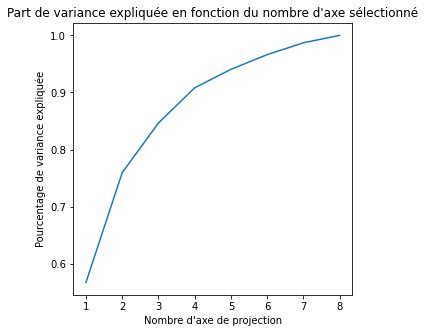

In [151]:
#proportion de variance expliquée par chaque axe
print(f"proportion de variance portée par chaque axe: {acp.explained_variance_ratio_}")

#Le but de l’ACP est de réduire significativement le nombre de dimensions (donc de variables) d’un jeu de données. 
#Pour cela, on projette les données sur les axes de “directions principales”, ie les axes qui préservent au mieux l’information, tout en réduisant la dimension. 
#La plupart du temps, on cherche à projeter sur 2 à 3 axes maximums, de manière à pouvoir visualiser les données.

# les 2 premiers axes expliquent 76% de la variance du nuage du point --> on prend ces 2 premiers axes pour représenter les gares dans le plan


#cumul de variance expliquée
fig,ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(1,p+1),np.cumsum(acp.explained_variance_ratio_)) 
ax.set_title("Part de variance expliquée en fonction du nombre d'axe sélectionné")
ax.set_ylabel("Pourcentage de variance expliquée")
ax.set_xlabel("Nombre d'axe de projection")
ax

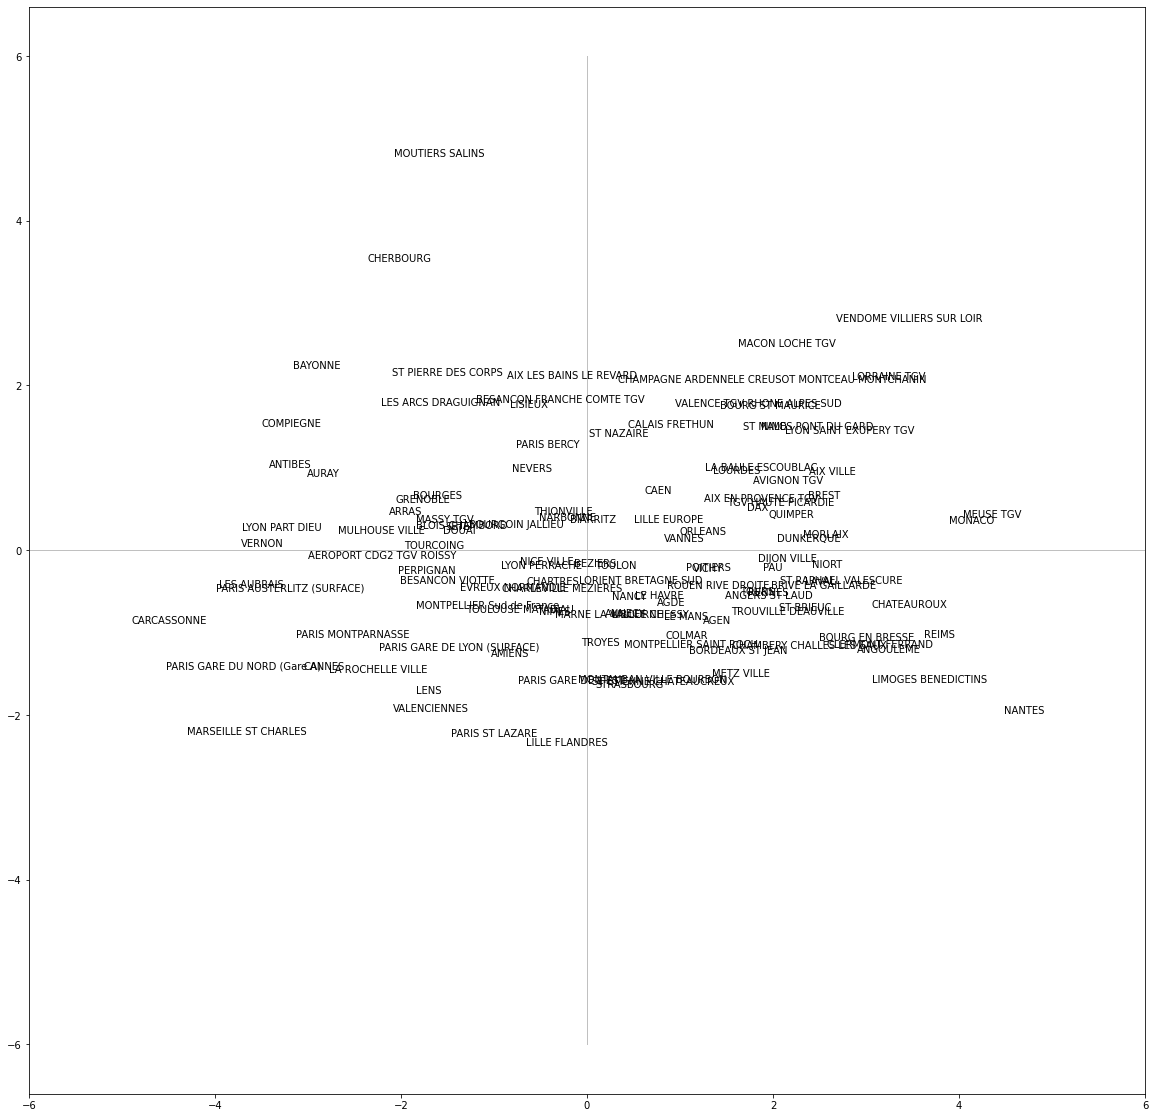

In [152]:
#représentation des gares dans le plan (direction principale 1, direction principale 2)
fig, axes = plt.subplots(figsize=(20,20)) 
axes.set_xlim(-6,6) #même limites en abscisse axes.set_ylim(-6,6) #et en ordonnée
#placement des étiquettes des observations
for i in range(n):
    plt.annotate(satis_2021.index[i],(coord[i,0],coord[i,1]))
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1) 
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
plt.show()

# les coordonnée d'une gare (considérée comme un point) sur chaque axe de direction principale représente la projection de ce point l'axe en question
# 

In [153]:
# Pour pouvoir interpréter les résultats obtenus, nous pouvons évaluer la contribution des différentes variables de satisfaction aux 2 directions principales

#corrélation des variables avec les axes
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

print(pd.DataFrame({'id':satis_2021.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

                               id     COR_1     COR_2
0            satisfaction globale  0.888723 -0.015936
1                    informations  0.797372  0.399882
2                    déplacements  0.787450  0.322477
3              propreté et sûreté  0.770130  0.453531
4          qualité moment en gare  0.888124  0.086959
5       commerces et les services  0.484405 -0.610721
6  architecture et les animations  0.538785 -0.734727
7                mobilité durable  0.765283 -0.383436


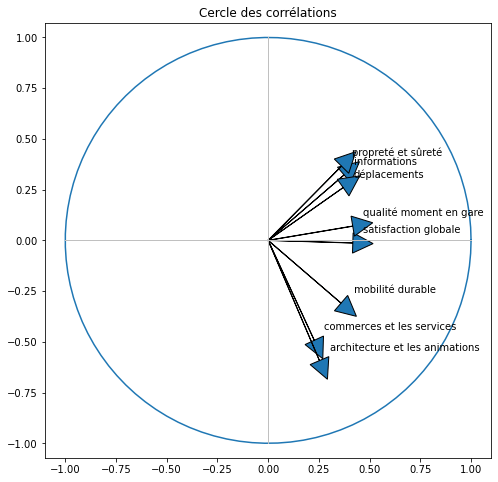

In [154]:
#Le cercle des corrélations est une représentation possible des résultats précédents:
#Ainsi, en observant la norme des vecteurs et les angles formés avec les deux directions, on trouve des informations sur la “consitution” des axes propres.
#La corrélation de chaque point sur un axe exprime la qualité de représentation du point sur l’axe. Elle prend des valeurs entre 0 (pas corrélé du tout) et 1 (fortement corrélé). Si cette valeur est proche de 1, alors le point est bien représenté sur l’axe.
#Par conséquent, plus un point est proche du centre, et plus il est mal expliqué par les axes. A l'inverse, plus les points sont proches du cercle, plus ils sont corrélés aux axes. 
#Enfin, si la flèche est proche d'un axe, cela signifie que l'axe permet de bien expliquer cette composante.
#Le fait que l'angle entre deux flèches soit faible signifie qu'elles sont très corrélées au sein du système d'axes obtenus (mais elles pourraient l'être beaucoup moins suivant d'autres axes). Toutefois, la grande part de variance obtenue avec ces deux axes permet de supposer que des flèches proches sur ce graphe sont en réalité corrélées.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, acp.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             acp.components_[0, i],  #0 for PC1
             acp.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(acp.components_[0, i] + 0.05,
             acp.components_[1, i] + 0.05,
             data_CR_df.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
#cercle unitaire
plt.plot(np.cos(an), np.sin(an))
#axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1) 
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

plt.axis('equal')
ax.set_title('Cercle des corrélations')
plt.show()

# a commenter avec https://www.soft-concept.com/surveymag/comment-lire-une-acp.html par exemple

#On constate que les différentes flèches peuvent se regrouper en 3 groupes (en terme de proximités d'angles), avec mobilité durable qui reste seul.

#Avec les deux axes obtenus par l'ACP, on constate un angle fermé entre qualité moment en gare et satisfaction globale. Celà signifique que sur les axes obtenus, les réponses des clients sur ces deux critères sont souvent les mêmes. 
#Graphiquement, il est possible que cette proximité s'explique par l'annulation en moyenne des autres facteurs autour du premier axe, mais aussi par le fait que la qualité du moment passé en gare est probablement le principal critère de satisfaction globale en gare.

#On constate une très forte corrélation entre les satisfactions liées aux commerces et services, et à l'architecture et aux animations. Ces deux paramètres peuvent en effet s'interpréter de façon plus globale comme étant des indicateurs du cadre offert par la gare, ce qui peut expliquer leur proximité (liens entre services et animations, et architecture et commerces)

#Le dernier groupe est celui regroupant propreté, sûreté, information, et déplacements. Il peut représenter l'aspect plus fonctionnel de la gare.


In [ ]:
#contributions
# a commenter 

cos2var = corvar**2
ctrvar = cos2var
for k in range(p):
    ctrvar[:,k] = ctrvar[:,k]/eigval[k]
#on n'affiche que pour les deux premiers axes
print(pd.DataFrame({'id':satis_2021.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))